In [26]:
import numpy as np 
import pandas as pd
import seaborn as sns
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
import torch
import torchvision.transforms as transforms
import tensorflow as tf
from tqdm import tqdm

In [27]:
df=pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
label=np.asarray(df["label"])
data=np.asarray(df.drop("label",axis=1).values).reshape(60000,1,28,28).astype('float32')
test=pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")
tlabel=np.asarray(test["label"])
tdata=np.asarray(test.drop("label",axis=1).values).reshape(10000,1,28,28).astype('float32')

In [28]:
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
def get_y(x):
    return labels[x]

In [29]:
class make_dataset(Dataset):
    def __init__(self,label,data,transform=None):
        self.labels=label
        self.images=data
        self.transform=transform
    def __getitem__(self,index):
        label = self.labels[index]
        image = self.images[index]
        if self.transform!=None:
            selfimage=self.transform(self.image)
        return image,label
    def __len__(self):
        return len(self.images)
    

In [30]:
train_set = make_dataset(label,data)
train_loader = DataLoader(train_set, batch_size=64)
test_set = make_dataset(tlabel,tdata)
test_loader = DataLoader(test_set, batch_size=64)


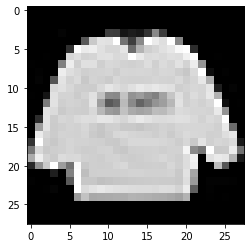

In [31]:
len(train_set)
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")

In [32]:
a = next(iter(train_loader))
print(a[0].size())

torch.Size([64, 1, 28, 28])


In [57]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
model=CNN_Model()
model

CNN_Model(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [58]:
num_epochs=5
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

error = nn.CrossEntropyLoss()
count=0
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        outputs = model(images)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
            
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                labels_list.append(labels)
                        
            
            
                outputs = model(images)
                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
    
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

 54%|█████▎    | 502/938 [01:13<03:41,  1.96it/s]

Iteration: 500, Loss: 0.5771865844726562, Accuracy: 85.9000015258789%


  7%|▋         | 64/938 [00:12<07:54,  1.84it/s]

Iteration: 1000, Loss: 0.23443062603473663, Accuracy: 88.94000244140625%


 60%|██████    | 564/938 [01:27<03:16,  1.90it/s]

Iteration: 1500, Loss: 0.33604374527931213, Accuracy: 89.19999694824219%


 13%|█▎        | 126/938 [00:20<07:03,  1.92it/s]

Iteration: 2000, Loss: 0.3010440468788147, Accuracy: 90.91000366210938%


 67%|██████▋   | 626/938 [01:35<02:43,  1.91it/s]

Iteration: 2500, Loss: 0.16028553247451782, Accuracy: 90.76000213623047%


 20%|██        | 188/938 [00:28<06:10,  2.03it/s]

Iteration: 3000, Loss: 0.36027106642723083, Accuracy: 90.33000183105469%


 73%|███████▎  | 688/938 [01:42<02:05,  1.99it/s]

Iteration: 3500, Loss: 0.17955777049064636, Accuracy: 90.9000015258789%


 27%|██▋       | 250/938 [00:36<06:16,  1.83it/s]

Iteration: 4000, Loss: 0.35400617122650146, Accuracy: 89.61000061035156%


 80%|███████▉  | 750/938 [01:50<01:33,  2.01it/s]

Iteration: 4500, Loss: 0.19173291325569153, Accuracy: 89.29000091552734%


100%|██████████| 938/938 [02:14<00:00,  6.95it/s]


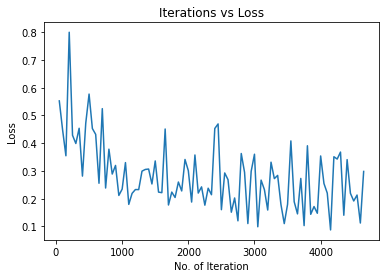

In [62]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

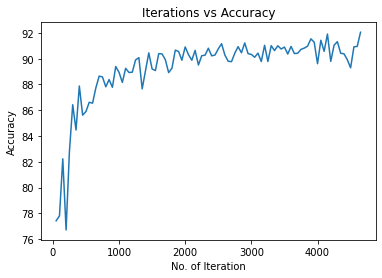

In [63]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()